In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from copy import deepcopy

import scipy.optimize

## Task 1

In [2]:
N = 100
a, b = 0, 10

x = np.linspace(a, b, num=N)

In [3]:
x = np.linspace(a, b, num=N)

cond_list_1 = [x < a + 1, (a + 1 <= x) & (x < a + 4), (a + 4 <= x) & (x < a + 9), x >= a + 9]
funclist_1 = [2, -3, 4, -2, 2]

y_piecelinear_discontinous = np.piecewise(x, condlist=cond_list_1, 
                                          funclist=funclist_1)
y_piecelinear_discontinous_corrupted = y_piecelinear_discontinous + np.random.normal(size=N) / 4

In [4]:
x = np.linspace(0, 3, num=N)

y_spline = (x - 1) ** 2
y_spline_corrupted = y_spline + np.random.normal(size=N) / 4

In [5]:
x = np.linspace(0, 3, num=N)

cond_list_1 = [x < 1, (1 <= x) & (x < 2), x >= 2]
funclist_1 = [lambda x: x, lambda x: -x + 2, lambda x: 2 * x - 4]

y_piecelinear_continous = np.piecewise(x, condlist=cond_list_1, 
                                          funclist=funclist_1)
y_piecelinear_continous_corrupted = y_piecelinear_continous + np.random.normal(size=N) / 4

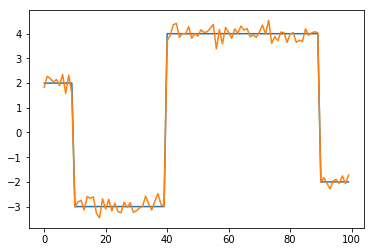

In [6]:
plt.plot(y_piecelinear_discontinous)
plt.plot(y_piecelinear_discontinous_corrupted)

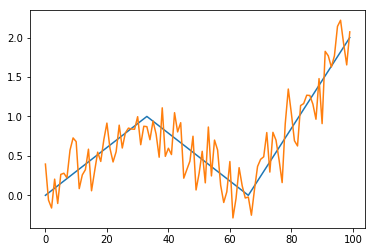

In [7]:
plt.plot(y_piecelinear_continous)
plt.plot(y_piecelinear_continous_corrupted)

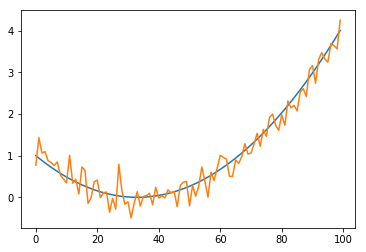

In [8]:
plt.plot(y_spline)
plt.plot(y_spline_corrupted)

In [9]:
D_0 = np.zeros((N - 1, N))
D_0[np.arange(0, N - 1, 1), np.arange(0, N - 1, 1)] = np.ones((N - 1))
D_0[np.arange(0, N - 1, 1), np.arange(1, N, 1)] = -np.ones((N - 1))

D_1 = np.zeros((N - 1, N))
D_1[np.arange(0, N - 1, 1), np.arange(0, N - 1, 1)] = np.ones((N - 1))
D_1[np.arange(0, N - 1, 1), np.arange(1, N, 1)] = -2 * np.ones((N - 1))
D_1[np.arange(0, N - 2, 1), np.arange(2, N, 1)] = 1 * np.ones((N - 2))

D_1 = D_1[:-1, :]

In [10]:
def recovery_proc(signal, gamma, penalty_matrix, norm_func):
    func = lambda x: np.linalg.norm(signal - x) ** 2 + gamma * norm_func(penalty_matrix @ x)
    res = scipy.optimize.minimize(fun=func, x0=np.random.rand(N))
    
    x_opt = res.x
    
    return x_opt

In [11]:
def apply_recovery(original_signal, corrupted_signal, gamma_min=0, gamma_max=2, iters_num=25):
    
    gammas = np.linspace(gamma_min, gamma_max, iters_num)
    
    explicit_D_0_l1 = []
    explicit_D_0_l2 = []
    explicit_D_1_l1 = []
    
    explicit_penalties_D_0_l1 = []
    explicit_penalties_D_0_l2 = []
    explicit_penalties_D_1_l1 = []
    
    for gamma in gammas:
        
        x_opt_D_0_l1 = recovery_proc(corrupted_signal, gamma, D_0, lambda x: np.sum(np.abs(x)))
        x_opt_D_0_l2 = recovery_proc(corrupted_signal, gamma, D_0, lambda x: np.linalg.norm(x) ** 2)
        x_opt_D_1_l1 = recovery_proc(corrupted_signal, gamma, D_1, lambda x: np.sum(np.abs(x)))
        
        diff_D_0_l1 = np.linalg.norm(x_opt_D_0_l1 - corrupted_signal)
        diff_D_0_l2 = np.linalg.norm(x_opt_D_0_l2 - corrupted_signal)
        diff_D_1_l2 = np.linalg.norm(x_opt_D_1_l1 - corrupted_signal)
        
        penalty_D_0_l1 = np.linalg.norm(D_0 @ x_opt_D_0_l1, ord=1)
        penalty_D_0_l2 = np.linalg.norm(D_1 @ x_opt_D_0_l2)
        penalty_D_1_l1 = np.linalg.norm(D_1 @ x_opt_D_1_l1, ord=1)
        
        explicit_D_0_l1 += [diff_D_0_l1]
        explicit_D_0_l2 += [diff_D_0_l2]
        explicit_D_1_l1 += [diff_D_1_l2]
        
        explicit_penalties_D_0_l1 += [penalty_D_0_l1]
        explicit_penalties_D_0_l2 += [penalty_D_0_l2]
        explicit_penalties_D_1_l1 += [penalty_D_1_l1]
        
    explicit_D_0_l1 = np.array(explicit_D_0_l1)
    explicit_D_0_l2 = np.array(explicit_D_0_l2)
    explicit_D_1_l1 = np.array(explicit_D_1_l1)
    
    explicit_penalties_D_0_l1 = np.array(explicit_penalties_D_0_l1)
    explicit_penalties_D_0_l2 = np.array(explicit_penalties_D_0_l2)
    explicit_penalties_D_1_l1 = np.array(explicit_penalties_D_1_l1)
    
    res_D_0_l1 = np.row_stack((explicit_D_0_l1, explicit_penalties_D_0_l1))
    res_D_0_l2 = np.row_stack((explicit_D_0_l2, explicit_penalties_D_0_l2))
    res_D_1_l1 = np.row_stack((explicit_D_1_l1, explicit_penalties_D_1_l1))
    
    
    return res_D_0_l1, res_D_0_l2, res_D_1_l1, gammas

### Piece wise linear continous

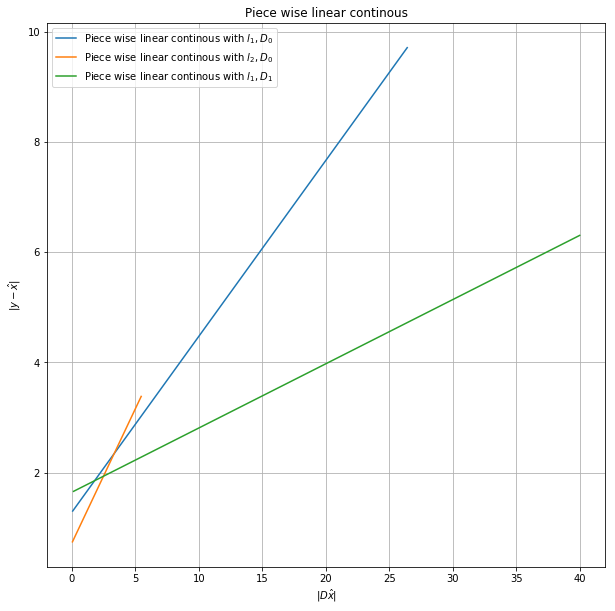

In [12]:
res_D_0_l1, res_D_0_l2, res_D_1_l1, gammas = apply_recovery(y_piecelinear_continous, 
                                                            y_piecelinear_continous_corrupted, 0.01, 5)

plt.figure(figsize=(10, 10))
plt.title('Piece wise linear continous')

plt.plot(res_D_0_l1[:, 0], res_D_0_l1[:, 1], label='Piece wise linear continous with ' + r'$ l_1, D_0 $')
plt.plot(res_D_0_l2[:, 0], res_D_0_l2[:, 1], label='Piece wise linear continous with ' + r'$ l_2, D_0 $')
plt.plot(res_D_1_l1[:, 0], res_D_1_l1[:, 1], label='Piece wise linear continous with ' + r'$ l_1, D_1 $')

plt.xlabel(r'$ \| D \hat{x} \|$')
plt.ylabel(r'$ \| y - \hat{x} \| $')

plt.grid()
plt.legend()

### Spline¶

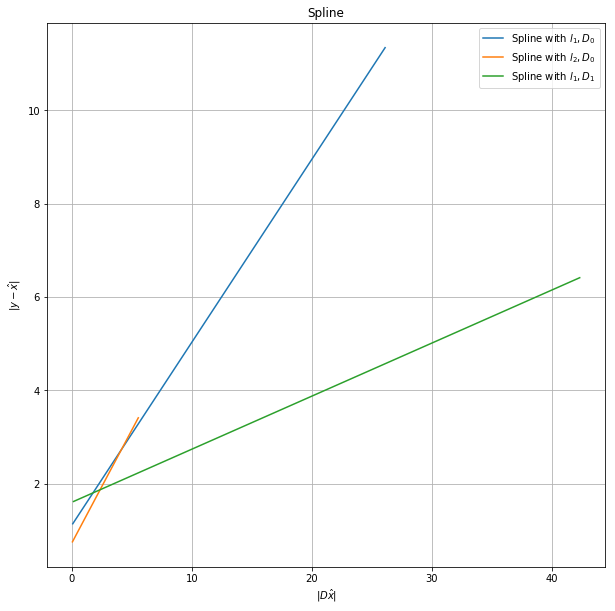

In [13]:
res_D_0_l1, res_D_0_l2, res_D_1_l1, gammas = apply_recovery(y_spline, y_spline_corrupted, 0.01, 5)

plt.figure(figsize=(10, 10))
plt.title('Spline')

plt.plot(res_D_0_l1[:, 0], res_D_0_l1[:, 1], label='Spline with ' + r'$ l_1, D_0 $')
plt.plot(res_D_0_l2[:, 0], res_D_0_l2[:, 1], label='Spline with ' + r'$ l_2, D_0 $')
plt.plot(res_D_1_l1[:, 0], res_D_1_l1[:, 1], label='Spline with ' + r'$ l_1, D_1 $')

plt.xlabel(r'$ \| D \hat{x} \|$')
plt.ylabel(r'$ \| y - \hat{x} \| $')

plt.grid()
plt.legend()

### Piece wise linear discontinous

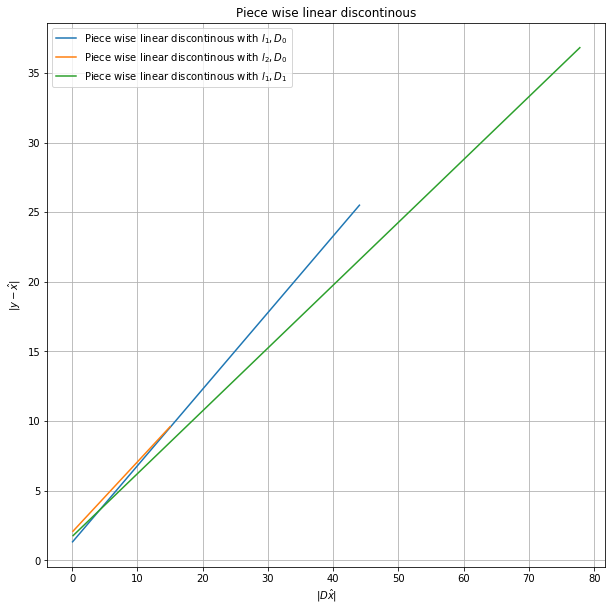

In [14]:
res_D_0_l1, res_D_0_l2, res_D_1_l1, gammas = apply_recovery(y_piecelinear_discontinous, 
                                                            y_piecelinear_discontinous_corrupted, 0.01, 5)

plt.figure(figsize=(10, 10))
plt.title('Piece wise linear discontinous')

plt.plot(res_D_0_l1[:, 0], res_D_0_l1[:, 1], label='Piece wise linear discontinous with ' + r'$ l_1, D_0 $')
plt.plot(res_D_0_l2[:, 0], res_D_0_l2[:, 1], label='Piece wise linear discontinous with ' + r'$ l_2, D_0 $')
plt.plot(res_D_1_l1[:, 0], res_D_1_l1[:, 1], label='Piece wise linear discontinous with ' + r'$ l_1, D_1 $')

plt.xlabel(r'$ \| D \hat{x} \|$')
plt.ylabel(r'$ \| y - \hat{x} \| $')

plt.grid()
plt.legend()

From the plots above, we can see, that for linear piece-wise discontinous function the best choise is using $ l_1 $ norm with $ D_0 $. Plots above describe the behaviour $  \| y - \hat{x} \| $ vs $ \| D_i \times \hat x \|_{l_j} $.
In fact, $ \| D_i \times \hat x \|_{l_j} $ describe smoothness of recovered signal and if  $ \| D_i \times \hat x \|_{l_j} $ is big, it means that signal is noisy, on the other hand, if $ \| D_i \times \hat x \|_{l_j} $ - over smoothing.

In [15]:
def plot_recoveries(original_signal, corrupted_signal, gammas = [], penalty = D_0, norm = None):
    
    fig, axs = plt.subplots(nrows=len(gammas), figsize=(12, 5 * len(gammas)))
    
    for gamma, ax in zip(gammas, axs.flatten()):
        
        recovered_signal = recovery_proc(corrupted_signal, gamma, penalty, norm)
        
        ax.plot(recovered_signal, 'r--', label='Recovered signal')
        ax.plot(corrupted_signal, 'b:', label='Corrupted signal')
        ax.plot(original_signal, 'g', label='Original signal')
        
        ax.legend()
        ax.grid()

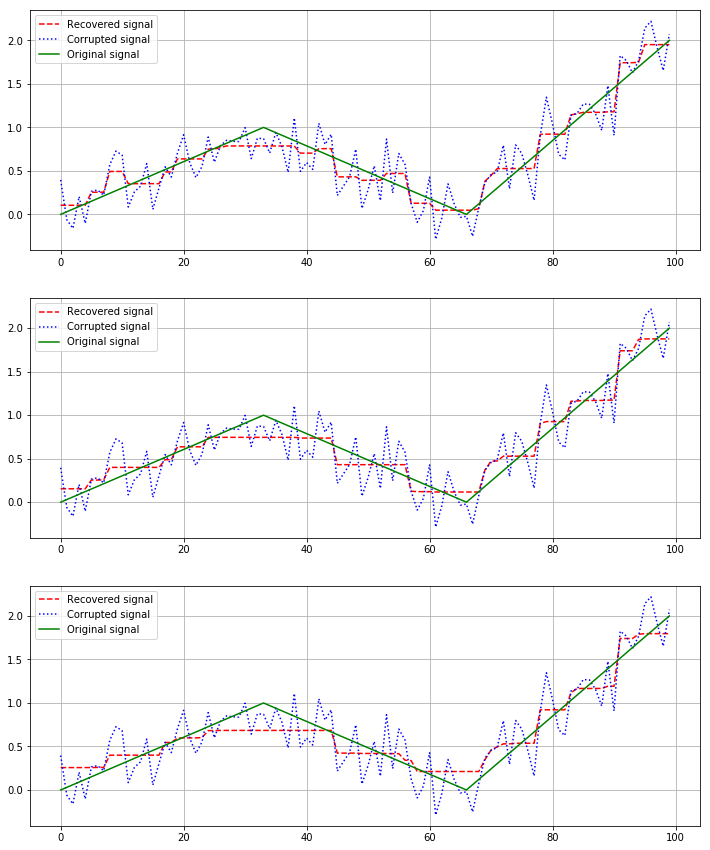

In [16]:
plot_recoveries(y_piecelinear_continous, 
                y_piecelinear_continous_corrupted, 
                gammas=[0.5, 1, 2], norm = lambda x: np.sum(np.abs(x)))

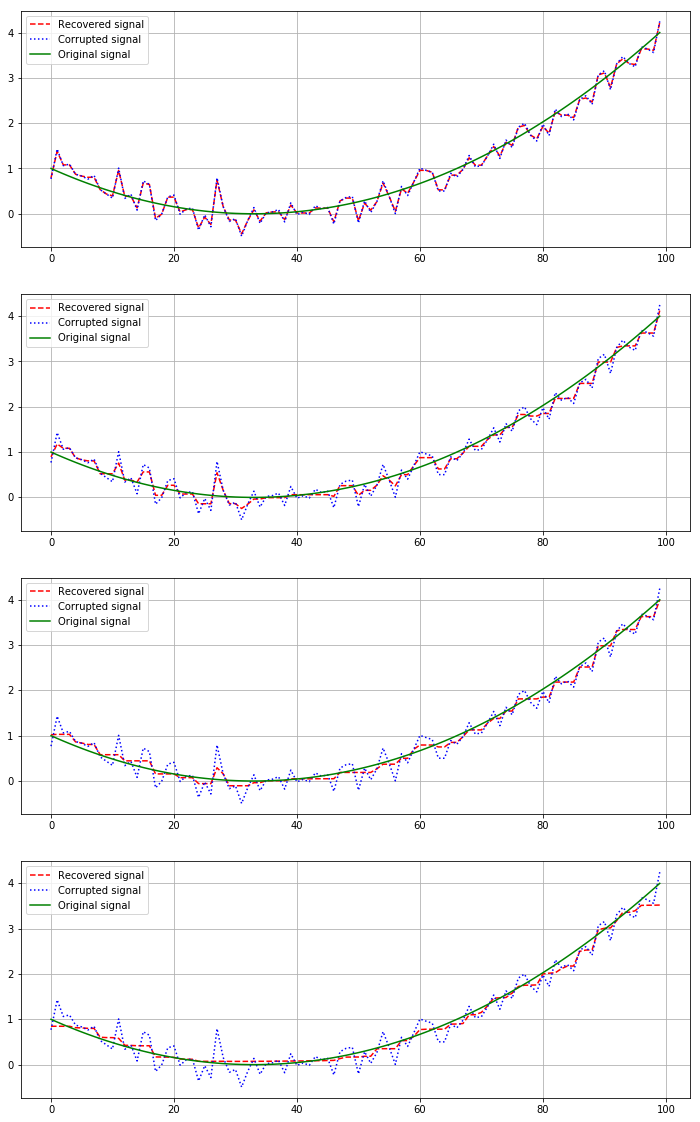

In [17]:
plot_recoveries(y_spline, 
                y_spline_corrupted, 
                gammas=[0.05, 0.25, 0.5, 2], norm = lambda x: np.sum(np.abs(x)))

## Task 2

$$
\begin{bmatrix}
    A & B \\
    B^\top & C
\end{bmatrix} \\
    X > 0, \implies A > 0, C - B^\top A^{-1} B > 0 \\
    X > 0, \implies C > 0, A - B C^{-1} B^\top > 0
$$
are called Schur complement.

$$
    a \in \mathcal{E} \leftrightarrow a \in \mathcal{E} = \left \{ (x - c)^\top P^{-1} (x - c) \leq q \right \}
$$
As matrix linear inequality:
$$
0 < (x - c)^\top P^{-1} (x - c) \leq 1 \implies 1 - (x - c)^\top P^{-1} (x - c) \geq 0
$$
where, $ B = (x - c), A = P $.
LMI for this task:
$$
    LMI = \begin{bmatrix}
        P & x - c \\
        (x - c)^\top & 1
    \end{bmatrix} \\
    LMI > 0
$$

### Task 3

Given N points: $ \mathcal{X} = \{ x_i \}_{i = 1}^N $.
$$ 
minimize \left [ log(det A) \right ] \\ 
\| A x_i + b \|^2_2 \leq 1, x_i \in \mathcal{X}
$$

### Solution

$$
\| A x_i + b \|^2_2 \leq 1 \implies \left ( A x_i + b \right )^\top \left ( A x_i + b \right ) \leq 1 \\
$$

As it was in the previous task, we can use Schur complement:
$$
0 < \left ( A x_i + b \right )^\top \left ( A x_i + b \right ) \leq 1 \\
0 < \left ( A x_i + b \right )^\top E^{-1} \left ( A x_i + b \right ) \leq 1 \\
1 - \left ( A x_i + b \right )^\top E^{-1} \left ( A x_i + b \right ) \leq 0 \\
\implies LMI = \begin{bmatrix}
    E & A x_i + b \\
    \left ( A x_i + b \right )^\top & 1
\end{bmatrix} > 0
$$

In [18]:
import numpy as np
import cvxpy as cvp
import cvxopt
import matplotlib.pyplot as plt
import cvxopt.lapack as lp
from matplotlib.patches import Ellipse
from itertools import combinations
import math
%matplotlib inline

In [19]:
def show_ellipse(X,fig,ax, A, b, color,show_plot,k=None,scatter_colot='red'):
    
    if k is None:
        k = len(X)
    
    sigma = np.linalg.inv(A.T.dot(A))
    mu = -sigma.dot(A.T).dot(b)
    vals, vecs = np.linalg.eigh(sigma)

    x, y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))

    w, h = 2 * np.sqrt(vals)
    
    ellipse = Ellipse(mu, w, h, theta, color=color)  # color="k")
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(0.2)
    
    ax.add_artist(ellipse)
    
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(X.T[0], X.T[1], color=scatter_colot)
    plt.grid(color='lightgray', linestyle='--')
    
    if show_plot:
        plt.show()

In [20]:
def solve(x, fig, ax, plot = True, show_plot = True, color="b"):

    n, m = x.shape
    A = cvp.Variable((m, m), PSD=True)
    b = cvp.Variable((m))
    constraints = [cvp.norm((x * A)[i] + b) <= 1 for i in np.arange(0,n,1)]

    obj = cvp.Minimize(-cvp.log_det(A))
    prob = cvp.Problem(obj, constraints)
    
    prob.solve(solver=cvp.CVXOPT)
    
    if plot:    
        show_ellipse(x, fig, ax, A.value, b.value, color, show_plot)
        
    return A.value, b.value, prob.value

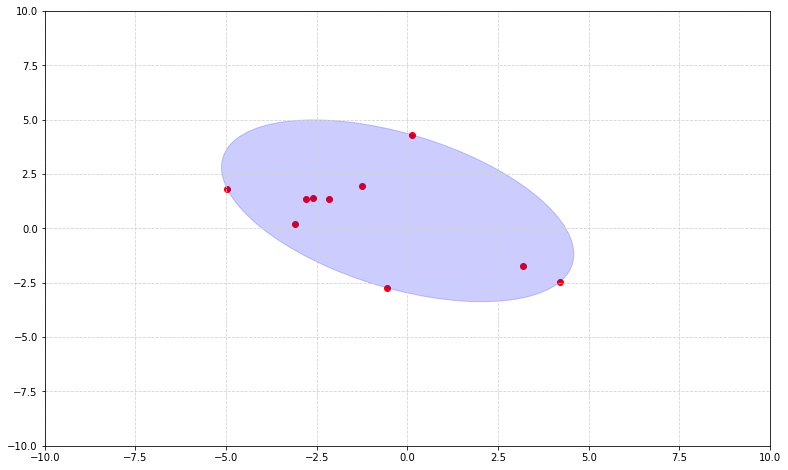

In [21]:
distrution = 10
n, m = 10,2
count = 0
x = np.random.rand(n,m) * distrution - 5
fig, ax = plt.subplots(figsize=(13, 8))
A,b,cost = solve(x,fig, ax)